## Using featurewiz with Day data only

This notebook is adapted from: https://www.kaggle.com/rsesha/wids-score-85-5-using-featurewiz-auto-viml
and https://www.kaggle.com/andradaolteanu/wids-datathon-rapids-fancy-impute-xgboost

Import Libraries 📚📚 

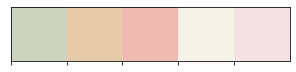

In [1]:
# CPU Libraries
import os
import random
import warnings
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

### Commenting out code from Kaggle book to replace try code above from fancyimpute import KNN, IterativeImputer

seed = 123
random.seed(seed)
np.random.seed(seed)

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

#so excited about this palette, though icecream may not be the best when doing predictions on diabetes...
icecream = ["#CCD4BF", "#E7CBA9", "#EEBAB2", "#F5F3E7", "#F5E2E4"]
sns.palplot(sns.color_palette(icecream))

## Import Data


In [2]:
train = pd.read_csv("TrainingWiDS2021.csv")
test = pd.read_csv("UnlabeledWiDS2021.csv")

In [3]:
train.shape

(130157, 181)

In [4]:
test.shape


(10234, 180)

In [5]:
encounter_id_test = test['encounter_id'].values

In [6]:
train.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,...,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,...,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [7]:
test.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,1,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,2,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,3,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,4,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,5,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,...,NaN,NaN,NaN,0,0,0,0,0,0,0


## Remove day data

From the WiDS Datathon Webinar(https://www.youtube.com/watch?v=cZ-trv7-j7k) Dr. Celi noted that it would be more helpful if the h1 data were predictive of diabetes because then ICU staff could make a prediction faster than if they had to wait for a full day to be able to make a prediction.  I will run both h1 and d1 through the model that has provided me the best results thus far and then note the difference.  This model will be for the d1 data.  As such we will eliminate all h1 data. We will also remove Unnamed: 0.ImportError: cannot import name 'create_time_series_features' from 'featurewiz.featurewiz' 


In [10]:
train = train.drop(['Unnamed: 0',
'h1_albumin_max',
'h1_albumin_min',
'h1_arterial_pco2_max',
'h1_arterial_pco2_min',
'h1_arterial_ph_max',
'h1_arterial_ph_min',
'h1_arterial_po2_max',
'h1_arterial_po2_min',
'h1_bilirubin_max',
'h1_bilirubin_min',
'h1_bun_max',
'h1_bun_min',
'h1_calcium_max',
'h1_calcium_min',
'h1_creatinine_max',
'h1_creatinine_min',
'h1_diasbp_invasive_max',
'h1_diasbp_invasive_min',
'h1_diasbp_max',
'h1_diasbp_min',
'h1_diasbp_noninvasive_max',
'h1_diasbp_noninvasive_min',
'h1_glucose_max',
'h1_glucose_min',
'h1_hco3_max',
'h1_hco3_min',
'h1_heartrate_max',
'h1_heartrate_min',
'h1_hemaglobin_max',
'h1_hemaglobin_min',
'h1_hematocrit_max',
'h1_hematocrit_min',
'h1_inr_max',
'h1_inr_min',
'h1_lactate_max',
'h1_lactate_min',
'h1_mbp_invasive_max',
'h1_mbp_invasive_min',
'h1_mbp_max',
'h1_mbp_min',
'h1_mbp_noninvasive_max',
'h1_mbp_noninvasive_min',
'h1_pao2fio2ratio_max',
'h1_pao2fio2ratio_min',
'h1_platelets_max',
'h1_platelets_min',
'h1_potassium_max',
'h1_potassium_min',
'h1_resprate_max',
'h1_resprate_min',
'h1_sodium_max',
'h1_sodium_min',
'h1_spo2_max',
'h1_spo2_min',
'h1_sysbp_invasive_max',
'h1_sysbp_invasive_min',
'h1_sysbp_max',
'h1_sysbp_min',
'h1_sysbp_noninvasive_max',
'h1_sysbp_noninvasive_min',
'h1_temp_max',
'h1_temp_min',
'h1_wbc_max',
'h1_wbc_min'], axis=1)

In [11]:
train.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,...,54.8,51.000000,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,...,342.5,236.666667,0,0,0,0,0,0,0,0
4,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0


In [12]:
test = test.drop(['Unnamed: 0',
'h1_albumin_max',
'h1_albumin_min',
'h1_arterial_pco2_max',
'h1_arterial_pco2_min',
'h1_arterial_ph_max',
'h1_arterial_ph_min',
'h1_arterial_po2_max',
'h1_arterial_po2_min',
'h1_bilirubin_max',
'h1_bilirubin_min',
'h1_bun_max',
'h1_bun_min',
'h1_calcium_max',
'h1_calcium_min',
'h1_creatinine_max',
'h1_creatinine_min',
'h1_diasbp_invasive_max',
'h1_diasbp_invasive_min',
'h1_diasbp_max',
'h1_diasbp_min',
'h1_diasbp_noninvasive_max',
'h1_diasbp_noninvasive_min',
'h1_glucose_max',
'h1_glucose_min',
'h1_hco3_max',
'h1_hco3_min',
'h1_heartrate_max',
'h1_heartrate_min',
'h1_hemaglobin_max',
'h1_hemaglobin_min',
'h1_hematocrit_max',
'h1_hematocrit_min',
'h1_inr_max',
'h1_inr_min',
'h1_lactate_max',
'h1_lactate_min',
'h1_mbp_invasive_max',
'h1_mbp_invasive_min',
'h1_mbp_max',
'h1_mbp_min',
'h1_mbp_noninvasive_max',
'h1_mbp_noninvasive_min',
'h1_pao2fio2ratio_max',
'h1_pao2fio2ratio_min',
'h1_platelets_max',
'h1_platelets_min',
'h1_potassium_max',
'h1_potassium_min',
'h1_resprate_max',
'h1_resprate_min',
'h1_sodium_max',
'h1_sodium_min',
'h1_spo2_max',
'h1_spo2_min',
'h1_sysbp_invasive_max',
'h1_sysbp_invasive_min',
'h1_sysbp_max',
'h1_sysbp_min',
'h1_sysbp_noninvasive_max',
'h1_sysbp_noninvasive_min',
'h1_temp_max',
'h1_temp_min',
'h1_wbc_max',
'h1_wbc_min'], axis=1)

In [13]:
test.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0


## Feature Engineering and Selection Using featurewiz library

There are now 116 columns in the dataset.  Featureviz can help us select the best features!

In [14]:
pip install featurewiz


Note: you may need to restart the kernel to use updated packages.


In [15]:
from featurewiz import featurewiz

Imported featurewiz: Auto_ViML's feature engg and selection library. Version=0.0.16
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Let featurewiz add features to your data! Set 'feature_engg' as: 'interactions' or 'groupby' or 'target'
                                


Skipping category encoding since no category encoders specified in input...
Shape of your Data Set loaded: (130157, 116)
    No GPU active on this device
    Running XGBoost using CPU parameters
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    115 Predictors classified...
        2 variable(s) removed since they were ID or low-information variables
#### Single_Label Binary_Classification Feature Selection Started ####
Starting feature engineering...this will take time...
Source X_train shape:  (130157, 113) | X_test shape:  (10234, 113)
##################################################
> Start preprocessing with 113 variables
> Generate Categorical Encoded features
> Generate Target Encoded categorical features
 + To know more, click: https://contrib.scikit-learn.org/category_encoders/targetencoder.html
 + added  6  additional Features using  TargetEncoder
> Cleaned NaNs in numeric features
#########################

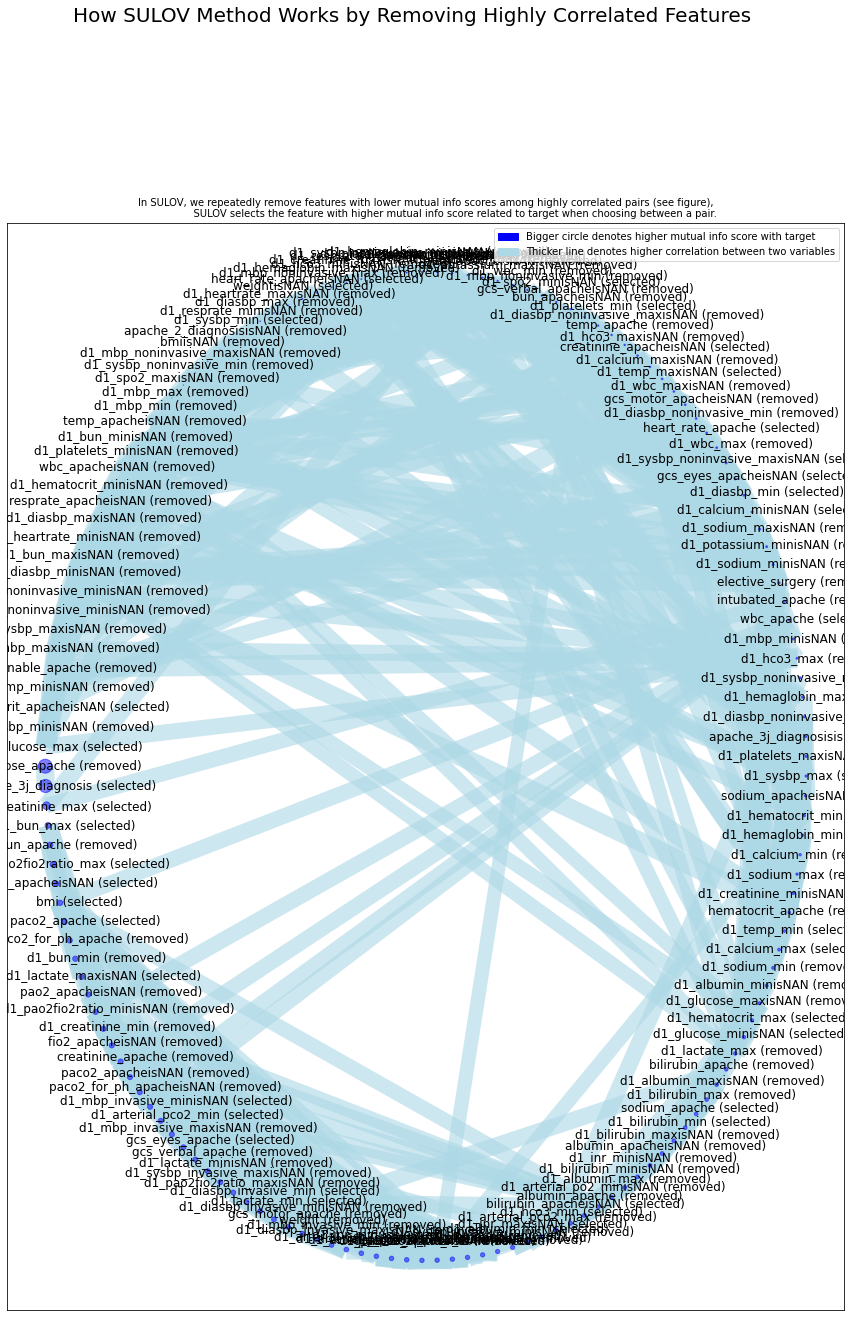

    Adding 6 categorical variables to reduced numeric variables  of 92
############## F E A T U R E   S E L E C T I O N  ####################
Current number of predictors = 98 
    Finding Important Features using Boosted Trees algorithm...
        using 98 variables...
        using 78 variables...
        using 58 variables...
        using 38 variables...
        using 18 variables...
Selected 52 important features from your dataset
    Time taken (in seconds) = 236
Returning list of 52 important features and dataframe.
Returning 2 dataframes: train and test with 52 important features.


In [16]:
#define target
target = 'diabetes_mellitus'
output = featurewiz(dataname=train, target=target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data=test,
                    feature_engg=['target'], category_encoders='')


It returned 52 important features and took 236 second to run.


In [17]:
## there are two parts of the tuple output.
# One is the new train dataset and the other is new dataset
len(output)

2

## Using Auto_ViML
Now the we'll use autoviml on the new train and test sets that were created by featurewiz...
(autoviml is already installed)

In [18]:
from autoviml.Auto_ViML import Auto_ViML

Imported Auto_NLP version: 0.0.45.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)
Imported Auto_ViML version: 0.1.677. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=1)
            
The new Auto_ViML can solve multi-label, multi-output problems. Check if your version is >= 0.1.669
To get the latest version, perform "pip install autoviml --no-cache-dir --

In [19]:
idcol = "encounter_id"

In [20]:
encounter_id_test = test[idcol].values

In [21]:
traindf, testdf = output[0], output[1]
print(traindf.shape, testdf.shape)

(130157, 53) (10234, 52)


In [22]:
target

'diabetes_mellitus'

##############  D A T A   S E T  A N A L Y S I S  #######################
Training Set Shape = (130157, 53)
    Training Set Memory Usage = 34.51 MB
Test Set Shape = (10234, 52)
    Test Set Memory Usage = 2.63 MB
Single_Label Target: ['diabetes_mellitus']
Random shuffling the data set before training
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
       Class  -> Counts -> Percent
           0:  102006  ->   78.4%
           1:   28151  ->   21.6%
    Target diabetes_mellitus is already numeric. No transformation done.
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
Data Set Shape: 130157 rows, 52 cols
Too many columns to print
    Numeric Columns: ['d1_glucose_max', 'bmi', 'age', 'd1_glucose_min', 'd1_creatinine_max', 'apache_2_diagnosis', 'd1_arterial_ph_min', 'd1_bun_max', 'apache_3j_diagnosis', 'd1_hco3_min', 'd1_lactate_min', 'sodium_apache', 'd1_sysbp_max', 'd1_hem

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.049567
0:	learn: 0.7961297	test: 0.7950215	best: 0.7950215 (0)	total: 176ms	remaining: 14m 38s


500:	learn: 0.8459832	test: 0.8370851	best: 0.8377766 (496)	total: 15s	remaining: 2m 14s
1000:	learn: 0.8590348	test: 0.8395052	best: 0.8400814 (963)	total: 30.5s	remaining: 2m 2s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.8400814382
bestIteration = 963

Shrink model to first 964 iterations.
    Actual training time (in seconds): 40
###########  Single_Label  M O D E L   R E S U L T S #################
5-fold Cross Validation logloss = 0.8400814382298709
    CatBoost Best Parameters for Model: Iterations = 963, learning_rate = 0.05
Finding Best Threshold for Highest F1 Score...


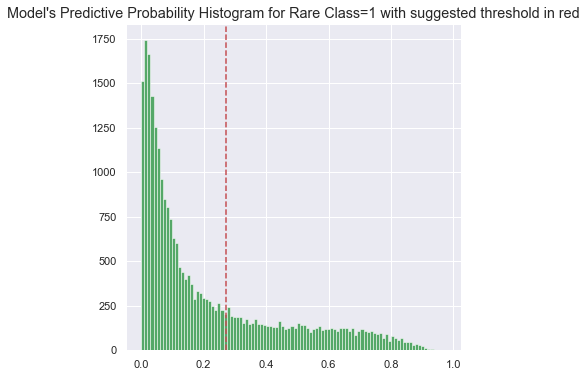

    Using threshold=0.5. However, 0.272 provides better F1=0.62 for rare class...
########################################################
CatBoost Model Prediction Results on Held Out CV Data Set:
    Regular Accuracy Score = 80.6%
Balanced Accuracy = 71.26% with Threshold = 0.50
Confusion Matrix:
[[19122  1280]
 [ 2883  2747]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     20402
           1       0.68      0.49      0.57      5630

    accuracy                           0.84     26032
   macro avg       0.78      0.71      0.74     26032
weighted avg       0.83      0.84      0.83     26032

Balanced Accuracy = 77.90% with Threshold = 0.27
Confusion Matrix:
[[16851  3551]
 [ 1509  4121]]
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     20402
           1       0.54      0.73      0.62      5630

    accuracy                           0.81     26032
   macro avg       0.73   

After multiple models, Ensemble Model Results:
Binary Class Model Metrics Report
#####################################################
    Accuracy          = 81.2%
    Balanced Accuracy = 76.1%
    Precision         = 55.3%
    Average Precision = 72.8%
    Recall            = 67.1%
    F1 Score          = 60.7%
#####################################################
              precision    recall  f1-score   support

           0       0.90      0.85      0.88     20402
           1       0.55      0.67      0.61      5630

    accuracy                           0.81     26032
   macro avg       0.73      0.76      0.74     26032
weighted avg       0.83      0.81      0.82     26032

[[17352  3050]
 [ 1852  3778]]
#############################################################################
Single Model is better than Ensembling Models for this data set.


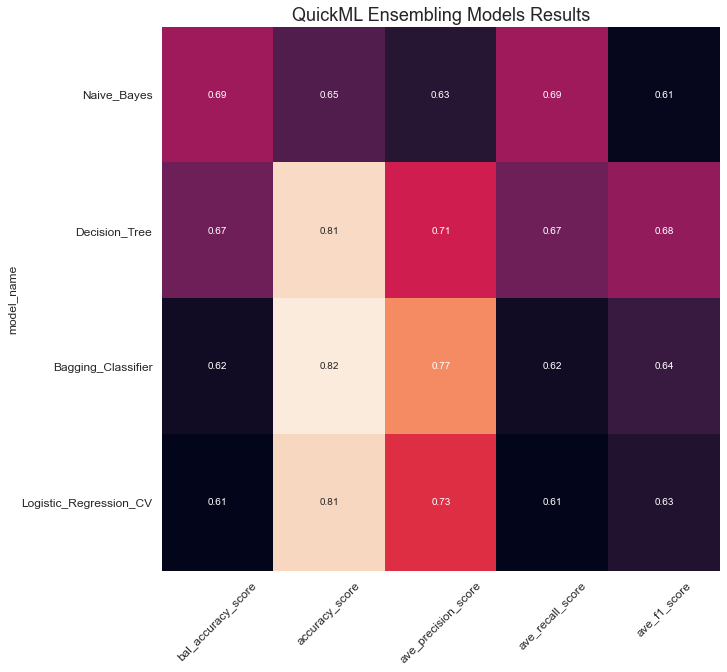

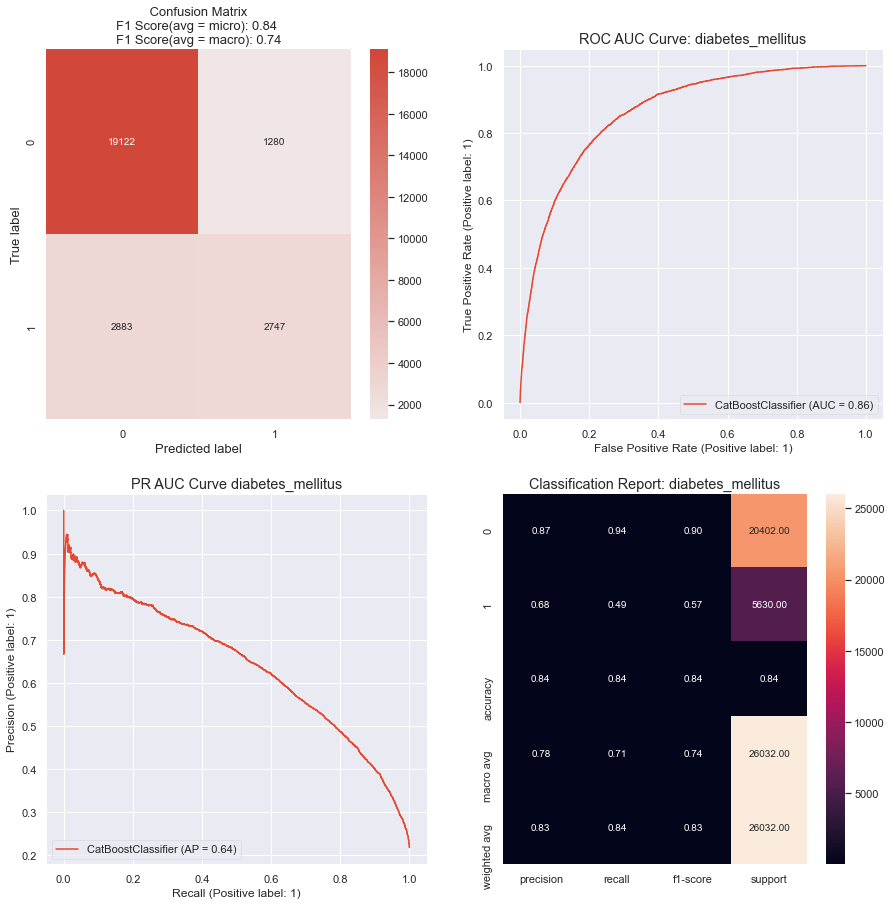

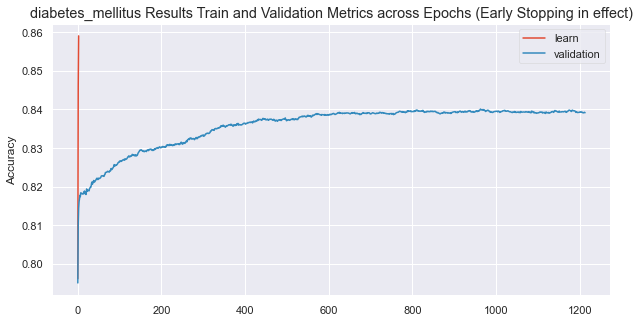

    Time taken for this Target (in seconds) = 77
    Binning_Flag set to False or there are no float vars in data set to be binned
    Setting best params for CatBoost model from Initial State since you cannot change params to a fitted Catboost model 
    Number of Categorical and Integer variables used in CatBoost training = 22
No MinMax scaling performed since scaling flag is set to false
#####   T R A I N I N G   M O D E L   O N    F U L L   T R A I N  D A T A  #############
0:	learn: 0.8020314	total: 41.8ms	remaining: 40.2s
500:	learn: 0.8451486	total: 20.8s	remaining: 19.2s
962:	learn: 0.8552441	total: 37.5s	remaining: 0us
     Actual Training time taken in seconds = 39
Training of models completed. Now starting predictions on test data...
    Making test Data predictions using modified Threshold = 0.272
    Calculating weighted average ensemble of 5 classifiers
    Plotting Feature Importances to explain the output of model
Could not draw feature importance plot due to an error
T

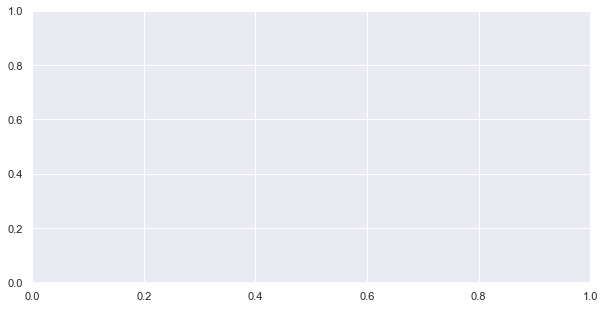

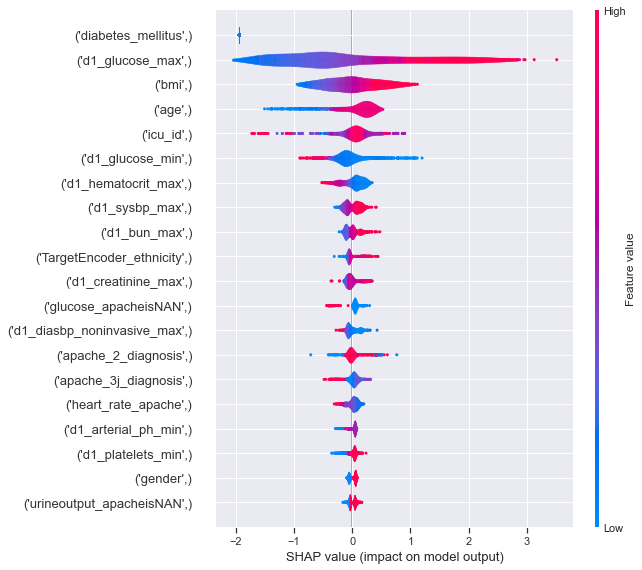

############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken thus far (in seconds) = 152
Writing Output files to disk...
    Saving predictions to .\diabetes_mellitus\diabetes_mellitus_Binary_Classification_test_modified.csv
    Saving predictions to .\diabetes_mellitus\diabetes_mellitus_Binary_Classification_submission.csv
    Saving predictions to .\diabetes_mellitus\diabetes_mellitus_Binary_Classification_train_modified.csv
###############  C O M P L E T E D  ################
Time Taken in mins = 2.6 for the Entire Process


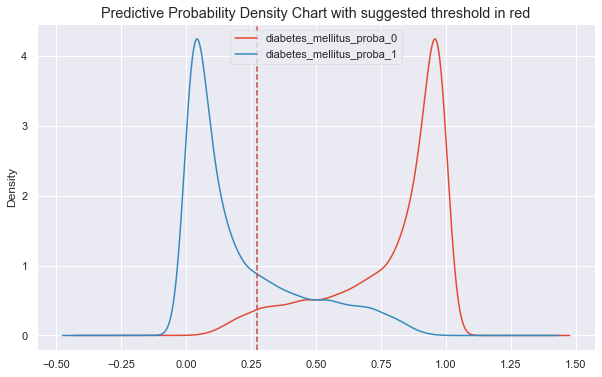

In [23]:
### we will turn off feature_reduction since we have already done that!
m, features, trainm, testm = Auto_ViML(traindf, target, testdf,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=False,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=2)

In [25]:
testm.head(1)

,ventilated_apache,glucose_apacheisNAN,arf_apache,d1_glucose_minisNAN,apache_3j_diagnosisisNAN,gcs_eyes_apacheisNAN,ageisNAN,creatinine_apacheisNAN,d1_inr_maxisNAN,gcs_unable_apacheisNAN,urineoutput_apacheisNAN,lymphoma,cirrhosis,ph_apacheisNAN,d1_calcium_minisNAN,d1_temp_maxisNAN,hematocrit_apacheisNAN,d1_resprate_maxisNAN,d1_sysbp_noninvasive_maxisNAN,d1_spo2_minisNAN,weightisNAN,heart_rate_apacheisNAN,d1_glucose_max,bmi,age,d1_glucose_min,d1_creatinine_max,apache_2_diagnosis,d1_arterial_ph_min,d1_bun_max,apache_3j_diagnosis,d1_hco3_min,d1_lactate_min,sodium_apache,d1_sysbp_max,d1_hematocrit_max,d1_bilirubin_min,d1_calcium_max,d1_inr_min,heart_rate_apache,d1_diasbp_noninvasive_max,d1_platelets_min,d1_sysbp_min,gcs_eyes_apache,TargetEncoder_ethnicity,icu_id,ethnicity,icu_type,gender,icu_admit_source,icu_stay_type,hospital_admit_source,diabetes_mellitus_proba_0,diabetes_mellitus_proba_1,diabetes_mellitus_predictions,diabetes_mellitus_Logistic_Regression_CV_predictions,diabetes_mellitus_Decision_Tree_predictions,diabetes_mellitus_Naive_Bayes_predictions,diabetes_mellitus_Bagging_Classifier_predictions,diabetes_mellitus_CatBoost_predictions,diabetes_mellitus_Ensembled_predictions
0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,104.00,27.60,72,97.00,1.49,110.00,7.34,44.00,104.01,23.00,1.50,130.00,149.00,42.80,1.90,9.80,1.20,38.00,104.00,173.00,76.00,4.00,0.21,82,3,5,1,1,0,4,0.95,0.05,0.00,0,0,0,0,0.00,0


In [26]:
# Add encounter_id and diabetes_mellitus back to the dataframes
subm = pd.DataFrame([], columns = [idcol,target])
subm[target] = testm[target+'_proba_1'].values
subm[idcol] = encounter_id_test
subm.head()

,encounter_id,diabetes_mellitus
0,144740,0.05
1,141990,0.15
2,142038,0.21
3,138628,0.05
4,141682,0.41


In [27]:
subm.to_csv("JDsub8.csv", index=False)